1. Understand how LSTM works for Time Series?
2. Train a LSTM model.
3. Compare LSTM vs Seasonal Naive/LightBGM

In [26]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential

plt.style.use("seaborn-v0_8-darkgrid")

In [10]:
train_df = pd.read_csv("../results/Delhi_Hourly_train.csv", parse_dates=["ds"])
test_df = pd.read_csv("../results/Delhi_Hourly_test.csv", parse_dates=["ds"])

train_df

,ds,y,temp,dwpt,rhum,wdir,wspd,pres,hour,weekday,month,is_weekend,hour_sin,hour_cos,lag_1,lag_24,lag_168,rolling_mean_3,rolling_mean_24
0,2021-01-08 00:00:00,4697.857500,13.0,11.60,91.0,145.0,2.7,1014.85,0,4,1,0,0.000000,1.000000,6723.608333,6557.406667,1975.541667,6566.744722,5909.383785
1,2021-01-08 01:00:00,4430.386667,13.0,12.10,94.0,0.0,0.0,1014.00,1,4,1,0,0.258819,0.965926,4697.857500,6331.355833,1805.590000,6048.358056,5831.902569
2,2021-01-08 02:00:00,4238.806667,12.6,12.15,97.0,0.0,0.0,1014.40,2,4,1,0,0.500000,0.866025,4430.386667,6075.757500,1665.914167,5283.950833,5752.695521
3,2021-01-08 03:00:00,4055.965833,12.1,12.10,100.0,0.0,0.0,1013.90,3,4,1,0,0.707107,0.707107,4238.806667,5798.060000,1607.331667,4455.683611,5676.155903
4,2021-01-08 04:00:00,3894.686667,12.0,12.00,100.0,0.0,0.0,1013.00,4,4,1,0,0.866025,0.500000,4055.965833,5545.454167,1676.528333,4241.719722,5603.568646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27528,2024-02-29 00:00:00,2081.147500,18.0,10.35,61.0,290.0,7.6,1015.40,0,3,2,0,0.000000,1.000000,2720.321667,2053.207500,2091.685833,2785.581944,3036.565938
27529,2024-02-29 01:00:00,1917.576667,17.5,10.00,61.5,280.0,6.5,1014.50,1,3,2,0,0.258819,0.965926,2081.147500,1885.863333,1930.974167,2507.263611,3037.730104
27530,2024-02-29 02:00:00,1826.179167,16.0,10.45,70.0,255.0,6.2,1014.00,2,3,2,0,0.500000,0.866025,1917.576667,1814.252500,1843.295833,2239.681944,3039.051493
27531,2024-02-29 03:00:00,1791.240833,14.5,11.00,79.5,250.0,7.3,1014.00,3,3,2,0,0.707107,0.707107,1826.179167,1781.202500,1817.735833,1941.634444,3039.548438


LSTM works best when:
1. feature count is small
2. signal is sequential.

In [11]:
features = ["y", "temp", "hour_sin", "hour_cos"]

In [15]:
scaler = StandardScaler()
train_scale = scaler.fit_transform((train_df[features]))        # Learns the params and applies to same data.
test_scale = scaler.transform(test_df[features])                # Applies parameters like mean, std, etc.

In [19]:
train_scale.shape

(27533, 4)

# Sequence Creation
LSTM sees a window of time instead of rows. Take values of last 24 hours -> Predict the next time step value.

In [16]:
def create_sequences(data, seq_len=24):
    X, y = [], []
    for i in range(seq_len, len(data)): # Ensures there are 'seq_len' previous points available for each sample.
        X.append(data[i-seq_len:i])     # Create input sequences - sliding window of length seq_len. 25-25 -> data[0:25].
        y.append(data[i,0])             # Create target values  -  0 is the first feature - target is the next time step.
    return np.array(X), np.array(y)

SEQ_LEN = 24

X_train, y_train = create_sequences(train_scale, SEQ_LEN)
X_test, y_test = create_sequences(test_scale, SEQ_LEN)

X_train.shape, X_test.shape

((27509, 24, 4), (6860, 24, 4))

In [27]:
model = Sequential([
    LSTM(64, input_shape=(SEQ_LEN, X_train.shape[2])),
    Dropout(0.2),
    Dense(1)
])

model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)

model.summary()

D:\Projects\Energy_Demand_Forecast\env\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)             │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,729 (69.25 KB)

 Trainable params: 17,729 (69.25 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Train LSTM and use EarlyStopping to avoid overfitting.
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0343 - mae: 0.0951 - val_loss: 0.0285 - val_mae: 0.0772
Epoch 2/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0337 - mae: 0.0945 - val_loss: 0.0285 - val_mae: 0.0774
Epoch 3/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0339 - mae: 0.0943 - val_loss: 0.0280 - val_mae: 0.0778
Epoch 4/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0339 - mae: 0.0950 - val_loss: 0.0288 - val_mae: 0.0776
Epoch 5/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0334 - mae: 0.0949 - val_loss: 0.0280 - val_mae: 0.0783
Epoch 6/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0330 - mae: 0.0944 - val_loss: 0.0304 - val_mae: 0.0819
Epoch 7/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0330 - mae: 0.0937 - val_loss: 0.0287 - val_mae: 0.0773
Epoch 8/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0324 - mae: 0.0938 - val_loss: 0.0302 - val_mae: 0.0781
Epoch 9/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - 

In [31]:
# Predict of test set.
lstm_pred_scaled = model.predict(X_test)

# Inverse scale predictions
lstm_pred = lstm_pred_scaled.flatten()

215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [32]:
# Eval LSTM
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse

lstm_mae, lstm_rmse = evaluate(y_test, lstm_pred)
print(f"LSTM -> MAE : {lstm_mae:.2f} and RMSE : {lstm_rmse:.2f}")

LSTM -> MAE : 0.09 and RMSE : 0.20


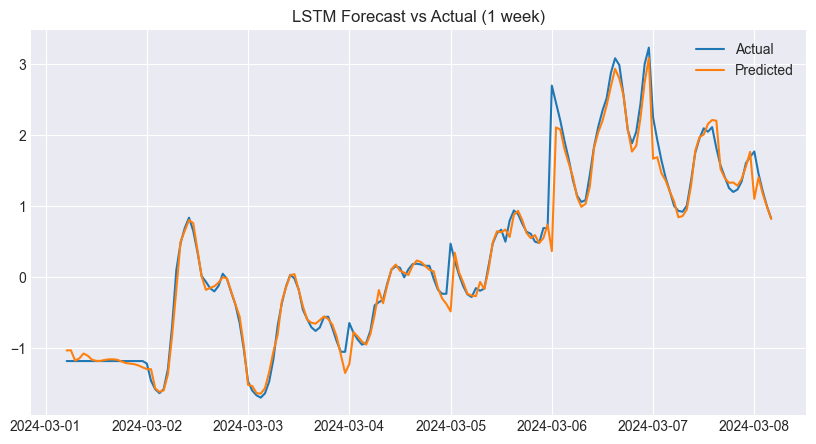

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(test_df.ds[SEQ_LEN:SEQ_LEN+168], y_test[:168], label="Actual")
plt.plot(test_df.ds[SEQ_LEN:SEQ_LEN+168], lstm_pred[:168], label="Predicted")
plt.title("LSTM Forecast vs Actual (1 week)")
plt.legend()
plt.show()

In [48]:
results = pd.DataFrame({
    "Model": [
        "Seasonal Naive",
        "Prophet",
        "LightGBM",
        "LSTM"
    ],
    "MAE": [
        560.21,
        2527.92,
        127.53,
        lstm_mae
    ],
    "RMSE": [
        876.42,
        2870.06,
        274.60,
        lstm_rmse
    ]
})

results

,Model,MAE,RMSE
0,Seasonal Naive,560.210000,876.420000
1,Prophet,2527.920000,2870.060000
2,LightGBM,127.530000,274.600000
3,LSTM,0.088974,0.195705


**LSTM fails here. As it is too good (MAE and RMSE) are both less than 1 which makes it suspiciously good. It means that there are very small deviations compared to the values given in the dataset.**